In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
from gpzoo.kernels import batched_MGGP_RBF
from gpzoo.gp import MGGP_WSVGP
from gpzoo.likelihoods import GaussianLikelihood
from gpzoo.utilities import whitened_KL

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
torch.manual_seed(14)

noise_variance = torch.tensor(0.05)
n0, n1 = 200, 200


X0 = distributions.Uniform(-10, 10).sample(sample_shape=(n0,1))
X1 = distributions.Uniform(-10, 10).sample(sample_shape=(n1,1))

X = torch.concatenate([X0, X1], axis=0)
X_groups = torch.concatenate([torch.zeros(n0), torch.ones(n1)]).type(torch.LongTensor)

In [3]:
kernel_true = batched_MGGP_RBF(sigma=4.0, lengthscale=1.5, group_diff_param=2.0)
kernel_true.input_dim = 1
cov = kernel_true.forward(X, X, X_groups, X_groups)+ noise_variance.expand(n0+n1).diag()
Y = distributions.MultivariateNormal(torch.zeros(len(X)), cov).sample()

In [4]:
Y.shape

torch.Size([400])

In [5]:
kernel = batched_MGGP_RBF(sigma=1.0, lengthscale=3.0, group_diff_param=0.1)

M = 100
gp = MGGP_WSVGP(kernel, dim=1, M=M, jitter=1e-5, n_groups=2)
gp.Z = nn.Parameter(20.0*torch.rand((M, 1))-10.0)
gp.mu = nn.Parameter(torch.randn((M)))
gp.Lu = nn.Parameter(torch.randn((M, M)))

model = GaussianLikelihood(gp, noise=1.0)

In [6]:
len(gp.groupsZ)

100

In [7]:
pY, qF, qU, pU = model(X=X, groupsX=X_groups, E=1)

In [8]:
qU

MultivariateNormal(loc: torch.Size([100]), scale_tril: torch.Size([100, 100]))

In [9]:
def train(model, optimizer, X, groupsX, y, steps=200, E=20):
    losses = []
    for it in tqdm(range(steps)):

        optimizer.zero_grad()
        pY, qF, qU, pU = model(X=X, groupsX=groupsX, E=E)

        ELBO = (pY.log_prob(y)).mean(axis=0).sum()

        ELBO -= torch.sum(whitened_KL(qU.mean, qU.scale_tril))


        loss = -ELBO
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    return losses

In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
losses = train(model, optimizer, X, X_groups, Y, steps=100000, E=3)

  0%|          | 0/100000 [00:00<?, ?it/s]

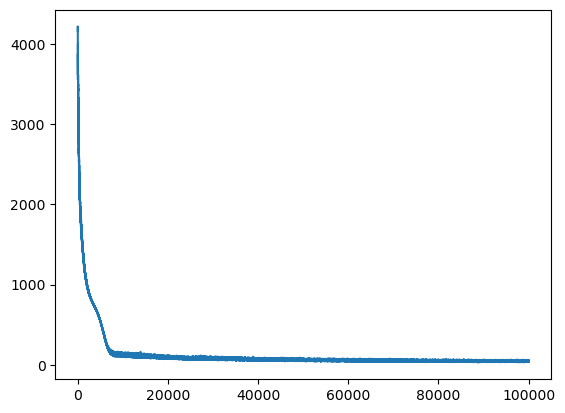

In [19]:
plt.plot(losses)

In [20]:
ntest = 500
Xtest_onegroup = torch.linspace(-10, 10, ntest)[:, None]
Xtest = torch.concatenate([Xtest_onegroup, Xtest_onegroup], axis=0)
Xtest_groups = torch.concatenate([torch.zeros(ntest), torch.ones(ntest)]).type(torch.LongTensor)
pY, qF, qU, pU = model(X=Xtest, groupsX=Xtest_groups, verbose=False)
mean = qF.mean.detach()

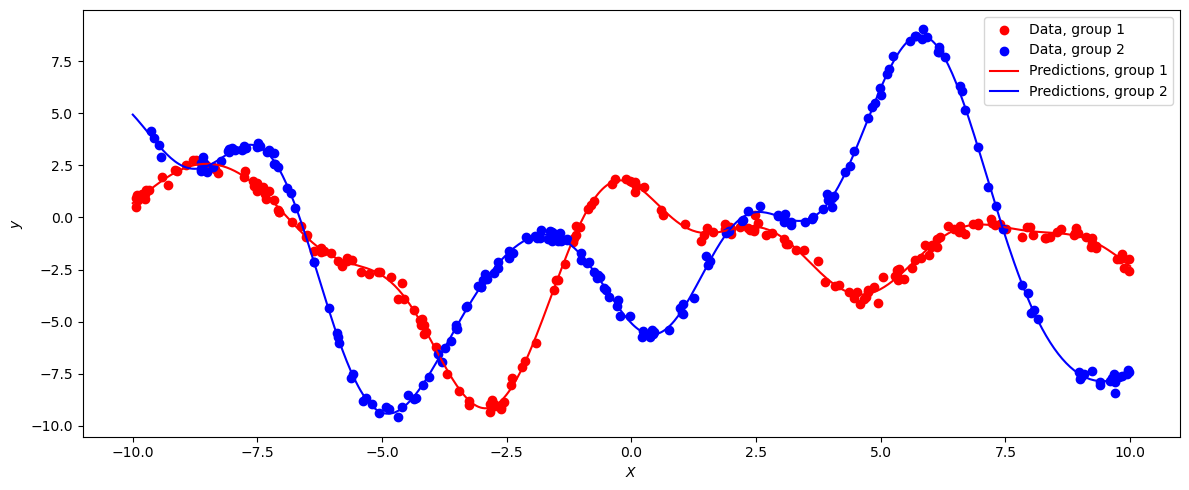

In [21]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(X[:n0], Y[:n0], color="red", label="Data, group 1")
ax.scatter(X[n0:], Y[n0:], color="blue", label="Data, group 2")
ax.plot(Xtest[:ntest], mean[:ntest], color="red", label="Predictions, group 1")
ax.plot(
    Xtest[ntest:], mean[ntest:], color="blue", label="Predictions, group 2"
)
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$y$")
ax.legend()
fig.tight_layout()

In [22]:
model.gp.kernel.lengthscale

Parameter containing:
tensor(1.4775, requires_grad=True)

In [23]:
model.gp.kernel.sigma

Parameter containing:
tensor(3.5699, requires_grad=True)

In [24]:
model.gp.kernel.group_diff_param

Parameter containing:
tensor(3.2382, requires_grad=True)

In [25]:
torch.nn.functional.softplus(model.noise)**2

tensor(0.0464, grad_fn=<PowBackward0>)